This project analyzes a synthetic hospital claims dataset to uncover patterns in treatmment costs, patient demographics, length of stay, and readmission rates. The goal is to simulate real-world workflows used by healthcare data analyst to generate actionable insights.

## **Necessary Setup and Package Installation**

In [1]:
# Core data and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ICD-10 CM package for diagnosis code mapping
!pip install icd10-cm
import icd10

# For plots
sns.set(style='whitegrid')
pd.set_option('display.max_columns', None)



## **Data Scan**

#### Load and Preview Dataset

In [2]:
path = '/content/drive/Othercomputers/Cyanosis/Datasets/synthetic_healthcare_data.csv'
df = pd.read_csv(path)
df.head()

,patient_id,visit_id,admission_date,discharge_date,age,gender,diagnosis_code,procedure_code,length_of_stay,total_cost,insurance_type,readmitted,mortality_flag
0,6b7b68e0-49cb-490a-b21d-4c72e48eb851,7aadea31-f2ca-437e-8ade-1facd2b8f513,2025-01-29,2025-02-05,44,Other,N18,27130,7,3399.03,Uninsured,0,0
1,90618e7f-0201-45ec-83b1-a4f00aec2174,933f7834-8148-4abb-abbc-56041011647c,2025-02-10,2025-02-12,26,Female,R07,30520,2,7400.02,Uninsured,0,0
2,a525cde1-9d5b-47a1-8977-f6e8ad4ddd35,e3d4edbf-ba94-45be-9c2f-7b5103672142,2024-08-27,NaN,64,Male,K21,30520,8,1335.23,Private,0,0
3,ce862c07-f4da-45a9-9b4b-9ba06cf9411d,27b7775e-69d9-42c9-93ca-17df0f5f608e,2024-09-03,2024-09-07,18,Female,J45,27130,4,1575.49,Private,0,0
4,10a5d6d7-a1d4-4680-ae3c-3028d1bac803,64bc5ed8-1ff3-45d9-9312-e33c30d9dbaa,2024-05-03,2024-05-11,67,Other,E11,99213,8,1687.64,Private,1,0


An overview of the dataset at first glance.

In [3]:
df.info() # Checks structure
df.describe() # Checks missingness and other stats
df.columns # Explores the columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   patient_id      500 non-null    object 
 1   visit_id        500 non-null    object 
 2   admission_date  500 non-null    object 
 3   discharge_date  487 non-null    object 
 4   age             500 non-null    int64  
 5   gender          500 non-null    object 
 6   diagnosis_code  500 non-null    object 
 7   procedure_code  500 non-null    int64  
 8   length_of_stay  500 non-null    int64  
 9   total_cost      500 non-null    float64
 10  insurance_type  500 non-null    object 
 11  readmitted      500 non-null    int64  
 12  mortality_flag  500 non-null    int64  
dtypes: float64(1), int64(5), object(7)
memory usage: 50.9+ KB


Index(['patient_id', 'visit_id', 'admission_date', 'discharge_date', 'age',
       'gender', 'diagnosis_code', 'procedure_code', 'length_of_stay',
       'total_cost', 'insurance_type', 'readmitted', 'mortality_flag'],
      dtype='object')


* The dataset contains **500 patient records** across **13 columns**, with complete data in most fields. Only `discharge_date` has missing entries (13 nulls), which will need to be cleaned before time-based calculations.
* Numerical fields such as `age`, `total_cost`, and `length_of_stay` have reasonable value ranges, though the **high standard deviation in cost** suggests **potential outliers** that may need to be capped or transformed.
* All necessary variables for clinical and financial analysis are present, including admission/discharge dates, diagnosis and procedure codes, cost, and outcome indicators like `readmitted` and `mortality_flag`. The column `length_of_stay` is already provided, but will be recalculated for validation.


## **Data Cleaning**

#### Parse Dates and Clean Missing Discharge Records

In [4]:
# Convert admission and discharge date to datetime
df['admission_date'] = pd.to_datetime(df['admission_date'], errors='coerce')
df['discharge_date'] = pd.to_datetime(df['discharge_date'], errors='coerce')

# Drop rows with missing discharge date.
df.dropna(subset=['discharge_date'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 487 entries, 0 to 499
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   patient_id      487 non-null    object        
 1   visit_id        487 non-null    object        
 2   admission_date  487 non-null    datetime64[ns]
 3   discharge_date  487 non-null    datetime64[ns]
 4   age             487 non-null    int64         
 5   gender          487 non-null    object        
 6   diagnosis_code  487 non-null    object        
 7   procedure_code  487 non-null    int64         
 8   length_of_stay  487 non-null    int64         
 9   total_cost      487 non-null    float64       
 10  insurance_type  487 non-null    object        
 11  readmitted      487 non-null    int64         
 12  mortality_flag  487 non-null    int64         
dtypes: datetime64[ns](2), float64(1), int64(5), object(5)
memory usage: 53.3+ KB


Converted date columns to datetime format and dropped rows with missing discharge_date to enable accurate time-based analysis.

####  Detect and Handle Cost Outliers

In [5]:
from scipy.stats import zscore

# Compute z-scores for cost
df['cost_zscore'] = zscore(df['total_cost'])

# Check how many values are above threshold
df['cost_zscore'].abs().gt(3).sum()


5

Identified **5 cost outliers** using the z-score method (>3 standard deviations from the mean).


In [6]:
q99 = df['total_cost'].quantile(0.99)
df['total_cost'] = np.where(df['total_cost'] > q99, q99, df['total_cost'])

* Instead of removing the outliers, I applied **99th percentile Winsorization** to cap extreme values while preserving legitimate high-cost cases typical in hospital billing.
* This approach controls skew without distorting clinical or financial insights.


#### Recalcuate and validate Length of Stay

In [7]:
# Recalculate length of stay
df['calculated_los'] = (df['discharge_date'] - df['admission_date']).dt.days

# Compare with existing values
(df['length_of_stay'] - df['calculated_los']).value_counts()


,count
0,487


 Recalculated length_of_stay using admission and discharge dates to validate the existing values. All 487 records matched exactly, confirming that the original length_of_stay column is accurate and can be used confidently in further analysis.

#### Mapping Diagnosis Codes to Descriptions Using ICD-10-CM

In [8]:
# Check if ICD-10 code exist
if icd10.exists("J20.0"):
    print("Exists")

# Function to get description for each diagnosis code
def get_icd_description(code):
    try:
        match = icd10.find(code)
        return match.description if match else 'Unknown Diagnosis'
    except:
        return 'Unknown Diagnosis'

# Apply to the dataset
df['diagnosis_name'] = df['diagnosis_code'].apply(get_icd_description)

# Preview result
df[['diagnosis_code', 'diagnosis_name']].head()


Exists


,diagnosis_code,diagnosis_name
0,N18,Chronic kidney disease (CKD)
1,R07,Pain in throat and chest
3,J45,Asthma
4,E11,Type 2 diabetes mellitus
5,J45,Asthma


* Mapped all `diagnosis_code` values to human-readable medical descriptions using the `icd10-cm` package.
* The mapping successfully translated clinical codes like `N18`, `J45`, and `E11` into descriptive terms such as:
  * `N18` → **Chronic kidney disease (CKD)**
  * `J45` → **Asthma**
  * `E11` → **Type 2 diabetes mellitus**
* This makes the data interpretable for both clinical and non-technical audiences.
* These mapped descriptions will now be used in visualizations and summaries, ensuring clarity when presenting cost drivers, admission trends, or patient outcomes.


## **Data Exploration**

#### 1. Most common Diagnoses

In [9]:
df['diagnosis_name'].value_counts().head(10)

,count
diagnosis_name,
Dorsalgia,61
Essential (primary) hypertension,60
Asthma,59
Type 2 diabetes mellitus,59
Pain in throat and chest,55
Chronic kidney disease (CKD),54
Gastro-esophageal reflux disease,52
"Encounter for general examination without complaint, suspected or reported diagnosis",46
"Major depressive disorder, single episode",41


* The most frequent diagnosis is Dorsalgia (back pain), followed closely by Essential hypertension, Asthma, and Type 2 diabetes mellitus, these reflect a high burden of chronic disease and musculoskeletal pain, which are common in both outpatient and inpatient settings.

* Mental health and routine check-up encounters also appear in the top 10, suggesting a mix of chronic disease management and preventive care.

#### 2. Most Common Insurance type

In [10]:
df['insurance_type'].value_counts()


,count
insurance_type,
Private,131
Medicare,128
Uninsured,124
Medicaid,104


Most patients were covered by Private (131) and Medicare (128) plans, followed by Uninsured (124) and Medicaid (104). Coverage is fairly balanced, with a notable share of uninsured patients.

#### 3. Cross Tab – Diagnosis × Insurance Type

In [11]:
pd.crosstab(df['diagnosis_name'], df['insurance_type'])


insurance_type,Medicaid,Medicare,Private,Uninsured
diagnosis_name,,,,
Asthma,10,14,15,20
Chronic kidney disease (CKD),8,21,11,14
Dorsalgia,12,15,25,9
"Encounter for general examination without complaint, suspected or reported diagnosis",13,12,11,10
Essential (primary) hypertension,13,14,18,15
Gastro-esophageal reflux disease,11,12,9,20
"Major depressive disorder, single episode",6,13,12,10
Pain in throat and chest,17,10,12,16
Type 2 diabetes mellitus,14,17,18,10


* **Private and Medicare** plans cover the largest share of patients across most diagnoses.
* **Asthma** and **GERD** have relatively high counts under **Uninsured**, suggesting possible gaps in access to chronic care.
* **Dorsalgia** (25) and **Type 2 diabetes** (18) are more commonly managed under **Private insurance**.
* **CKD** and **Hypertension** show higher Medicare representation, aligning with older demographics.


#### 4.  Cross Tab – Diagnosis × Gender

In [12]:
pd.crosstab(df['diagnosis_name'], df['gender'])


gender,Female,Male,Other
diagnosis_name,,,
Asthma,21,20,18
Chronic kidney disease (CKD),15,20,19
Dorsalgia,24,21,16
"Encounter for general examination without complaint, suspected or reported diagnosis",19,14,13
Essential (primary) hypertension,17,17,26
Gastro-esophageal reflux disease,16,17,19
"Major depressive disorder, single episode",13,17,11
Pain in throat and chest,19,22,14
Type 2 diabetes mellitus,13,25,21


* Most diagnoses are **evenly distributed across genders**, with minor variations.
* **Hypertension** and **Type 2 diabetes** have higher counts in **Male** and **Other** categories.
* **Dorsalgia** and **Asthma** are more common in **Females**.
* **CKD** and **GERD** show a relatively balanced distribution across all gender groups.

## **Data Visualization** *italicised text*

#### Plot of Top Diagnoses

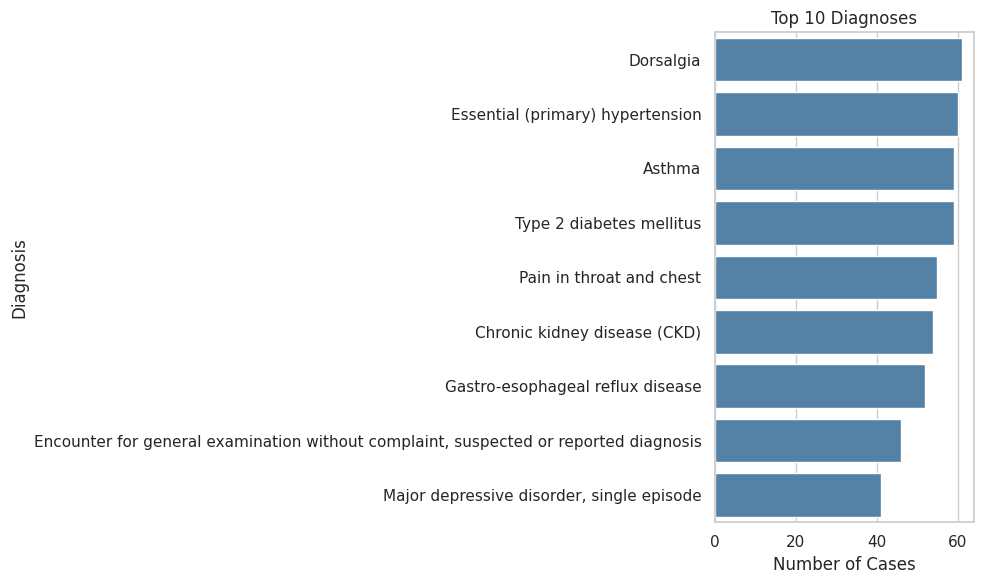

In [13]:
top_diag = df['diagnosis_name'].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_diag.values, y=top_diag.index, color='steelblue')
plt.title('Top 10 Diagnoses')
plt.xlabel('Number of Cases')
plt.ylabel('Diagnosis')
plt.tight_layout()
plt.show()


The most common diagnoses are Dorsalgia, Hypertension, Asthma, and Type 2 Diabetes, indicating a high burden of chronic and musculoskeletal conditions.

#### Plot of Diagnosis and Insurance Type

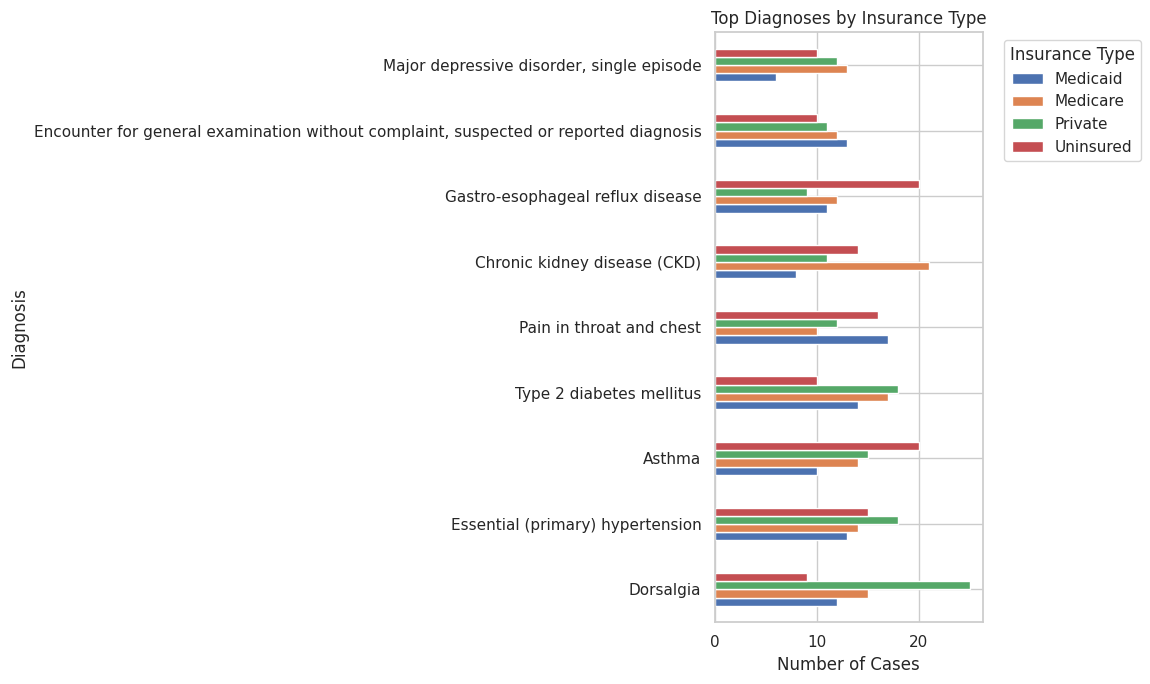

In [14]:
diag_insurance = pd.crosstab(df['diagnosis_name'], df['insurance_type']).loc[top_diag.index]

diag_insurance.plot(kind='barh', stacked=False, figsize=(12,7))
plt.title('Top Diagnoses by Insurance Type')
plt.xlabel('Number of Cases')
plt.ylabel('Diagnosis')
plt.legend(title='Insurance Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Private and Medicare plans cover most high-volume diagnoses. Asthma and GERD appear frequently under Uninsured, suggesting coverage disparities.

#### Plot of Diagnosis and Gender

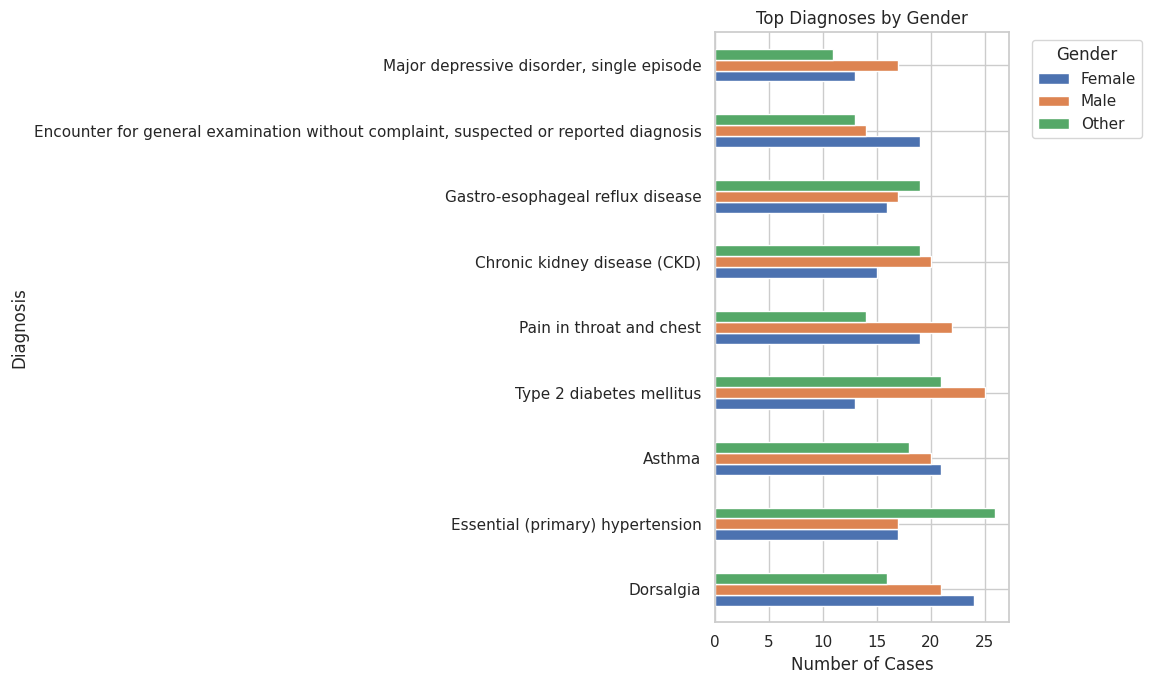

In [15]:
diag_gender = pd.crosstab(df['diagnosis_name'], df['gender']).loc[top_diag.index]

diag_gender.plot(kind='barh', stacked=False, figsize=(12,7))
plt.title('Top Diagnoses by Gender')
plt.xlabel('Number of Cases')
plt.ylabel('Diagnosis')
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Diagnoses are fairly evenly distributed across gender. Hypertension and Diabetes skew slightly Male, while Dorsalgia and Asthma are more Female-heavy.



## **Analysis**

I carried out cost - driver analysis to understand overall cost distribution, identify outliers, and rank diagnoses by average cost per case. This will help surface expensive conditions and potential targets for cost control.



#### 1. Cost Distribution Overview

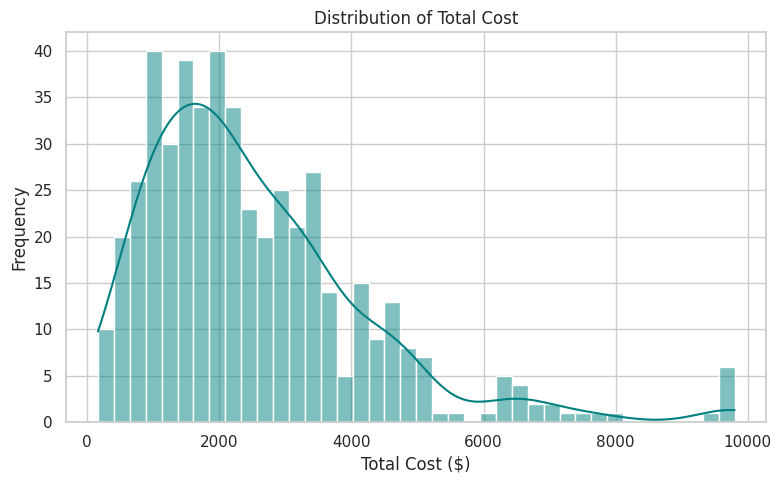

In [16]:
plt.figure(figsize=(8,5))
sns.histplot(df['total_cost'], bins=40, kde=True, color='teal')
plt.title('Distribution of Total Cost')
plt.xlabel('Total Cost ($)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


* The cost distribution is **right-skewed**, with most cases clustered between **\$1,000–\$3,000**.
* A long tail exists, but extreme high-cost cases have been capped at the **99th percentile** to preserve distribution shape while minimizing distortion.
* This cleaned cost data is now suitable for reliable per-diagnosis analysis and comparison.


#### 2. Average Cost per Diagnosis

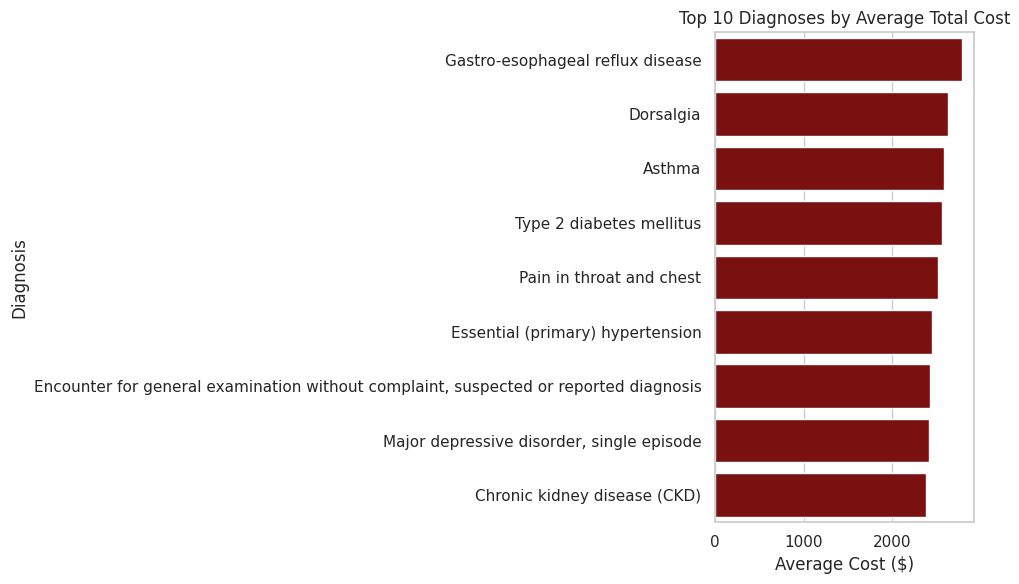

In [20]:
# Group and sort by mean cost
cost_per_diag = df.groupby('diagnosis_name')['total_cost'].mean().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=cost_per_diag.values, y=cost_per_diag.index, color='darkred')
plt.title('Top 10 Diagnoses by Average Total Cost')
plt.xlabel('Average Cost ($)')
plt.ylabel('Diagnosis')
plt.tight_layout()
plt.show()


* **Gastro-esophageal reflux disease (GERD)** tops the chart in average cost per case, followed closely by **Dorsalgia**, **Asthma**, and **Type 2 Diabetes**.
* Despite not being rare, these conditions show relatively high treatment costs, potentially due to longer care episodes, diagnostics, or follow-ups.
* **Chronic kidney disease** appears last among the top 10, but still represents a significant cost burden per case.



#### 3. Length of Stay (LOS) vs. Total Cost Analysis

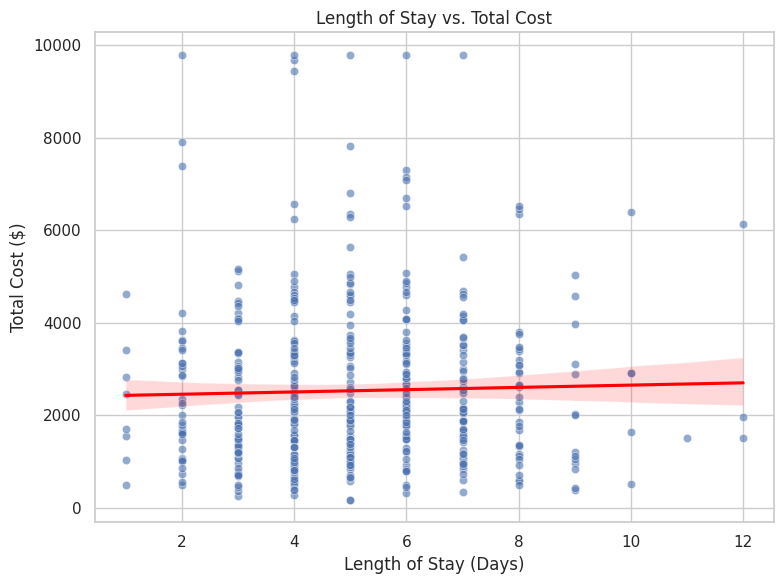

In [21]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='length_of_stay', y='total_cost', data=df, alpha=0.6)
sns.regplot(x='length_of_stay', y='total_cost', data=df, scatter=False, color='red')
plt.title('Length of Stay vs. Total Cost')
plt.xlabel('Length of Stay (Days)')
plt.ylabel('Total Cost ($)')
plt.tight_layout()
plt.show()


* The scatterplot shows a **weak positive trend** between **length of stay** and **total cost**.
* While longer stays slightly increase cost, the **variation is wide**, this means that cost is not strictly driven by duration alone.
* Other factors like **diagnosis, procedure type, and insurance coverage** likely contribute more to cost variability.


#### 4. Readmission Patterns by Diagnosis and Insurance Type

In [25]:
## a. Readmission Rate by Diagnosis
readmit_by_diag = df.groupby('diagnosis_name')['readmitted'].mean().sort_values(ascending=False).round(4)
readmit_by_diag.head(10)


,readmitted
diagnosis_name,
"Major depressive disorder, single episode",0.3171
Dorsalgia,0.2787
Pain in throat and chest,0.2727
Gastro-esophageal reflux disease,0.2115
Essential (primary) hypertension,0.1667
Type 2 diabetes mellitus,0.1525
"Encounter for general examination without complaint, suspected or reported diagnosis",0.1522
Chronic kidney disease (CKD),0.1481
Asthma,0.1186


* **Major depressive disorder** had the highest readmission rate at **31.71%**, followed by **Dorsalgia** (**27.87%**) and **Pain in throat and chest** (**27.27%**).
* **GERD** also showed elevated readmissions at **21.15%**.
* Chronic conditions like **Hypertension (16.67%)**, **Type 2 Diabetes (15.25%)**, and **CKD (14.81%)** had moderate readmission rates.
* **Asthma** had the lowest rate among top diagnoses at **11.86%**.



<ipython-input-28-b721ca0d114b>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=readmit_by_diag.values, y=readmit_by_diag.index, palette='viridis')


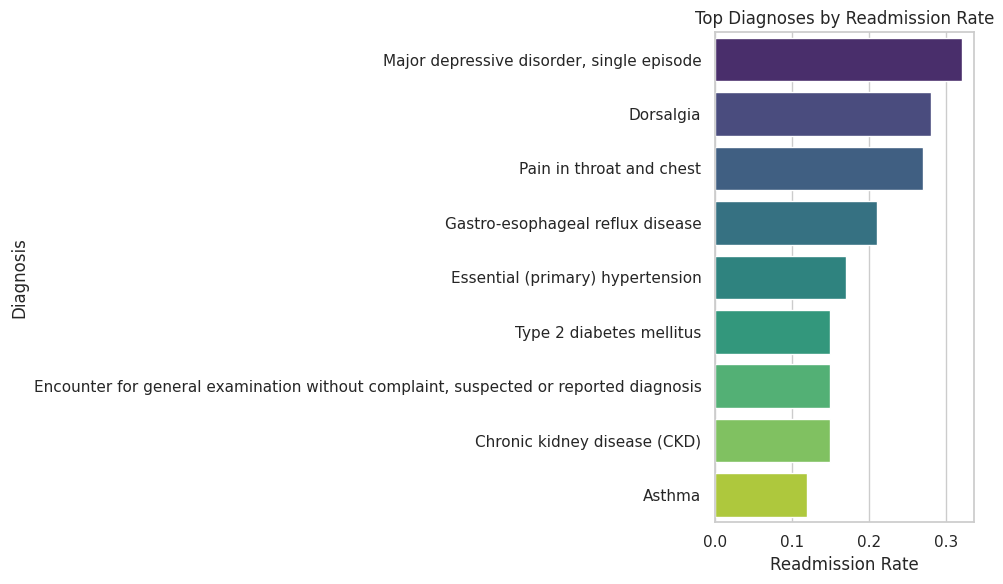

In [28]:
#  Bar Plot – Readmission Rate by Diagnosis
readmit_by_diag = df.groupby('diagnosis_name')['readmitted'].mean().sort_values(ascending=False).round(2).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=readmit_by_diag.values, y=readmit_by_diag.index, palette='viridis')
plt.title('Top Diagnoses by Readmission Rate')
plt.xlabel('Readmission Rate')
plt.ylabel('Diagnosis')
plt.tight_layout()
plt.show()


Mental health (Major depressive disorder) and pain-related conditions (Dorsalgia, Chest pain) showed the highest readmission rates, over 27%. These may need better discharge planning or follow-up care.



In [27]:
# b.Readmission Rate by Insurance Type
readmit_by_insurance = df.groupby('insurance_type')['readmitted'].mean().sort_values(ascending=False).round(4)
readmit_by_insurance


,readmitted
insurance_type,
Uninsured,0.2177
Medicare,0.2031
Medicaid,0.2019
Private,0.1756


* **Uninsured patients** had the highest readmission rate at **21.77%**, suggesting potential barriers to follow-up care.
* **Medicare** (20.31%) and **Medicaid** (20.19%) follow closely, possibly reflecting higher-risk or lower-income populations.
* **Privately insured patients** had the lowest readmission rate at **17.56%**, indicating relatively better continuity of care.


<ipython-input-29-11976f5b0792>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=readmit_by_insurance.values, y=readmit_by_insurance.index, palette='magma')


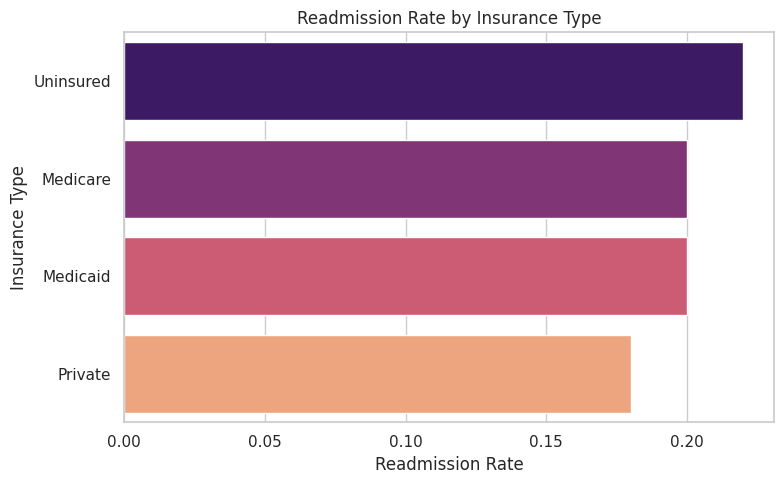

In [29]:
# Bar Plot – Readmission Rate by Insurance Type
readmit_by_insurance = df.groupby('insurance_type')['readmitted'].mean().sort_values(ascending=False).round(2)

plt.figure(figsize=(8,5))
sns.barplot(x=readmit_by_insurance.values, y=readmit_by_insurance.index, palette='magma')
plt.title('Readmission Rate by Insurance Type')
plt.xlabel('Readmission Rate')
plt.ylabel('Insurance Type')
plt.tight_layout()
plt.show()


Uninsured patients had the highest readmission rate (21.77%), followed by Medicare and Medicaid, suggesting possible gaps in care continuity or access.